# LCP mod. B – Exercise n. 1: Gradient Descent & DNNs

### List of students

```
Davide Bacilieri 2089214
Lorenzo Barbiero 2082142
Guglielmo Bordin 2088622
Alessio Pitteri  2090594
```

## Step 0. Importing Stuff

In [1]:
import numpy as np
import numpy.random as npr

import keras as kr
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras.optimizers as opt

from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='copper')
plt.rcParams['font.size'] = 15

import seaborn as sns

%run nonlinear_function.py

# set tensorflow seed for reproducibility
np.random.seed(123456)
import tensorflow.random as tfr
tfr.set_seed(123456)

## Step 1. Loading and Processing the Data
We’ll be doing cross validation later, so we’re not splitting the dataset in training and test sets until after we’ve chosen the best hyperparameters.

In [2]:
TYPE = 1
x = np.loadtxt(filename('data', TYPE), delimiter=' ')
y = np.loadtxt(filename('labels', TYPE), delimiter=' ')
N = len(x)     # number of samples
L = len(x[0])  # dimension of each sample

# rescaling of the data (as done in class)
x /= 50

print(f'Number of samples: {N}')

Number of samples: 4000


## Step 2. Definition of the Model
Here we build the architecture: we’ve chosen to build a network with four hidden layers of the same size followed by a single dropout layer. The output layer is a single neuron with sigmoid activation, to map the output to the range $(0, 1)$.

The module construction function requires three inputs: the dropout percentage for the second-to-last layer, the optimizer name, and the size of each hidden layer. We’ll optimize all of these parameters through a grid search later on.

In [3]:
# for some reason, GridSearchCV needs a default optimizer value here
def compile_model(dropout_rate, hlayer_size, optimizer=opt.Adam):
    # build DNN layer by layer
    model = Sequential()
    # input layer
    model.add(Dense(L, input_shape=(L, ), activation='relu'))
    # 4 hidden layers
    model.add(Dense(hlayer_size, activation='relu'))
    model.add(Dense(hlayer_size, activation='relu'))
    model.add(Dense(hlayer_size, activation='relu'))
    model.add(Dense(hlayer_size, activation='relu'))
    # dropout layer
    model.add(Dropout(dropout_rate))
    # last single-neuron layer
    model.add(Dense(1, activation='sigmoid'))

    # compile the model
    model.compile(loss=kr.losses.binary_crossentropy,
                  optimizer=optimizer(learning_rate=0.001),
                  metrics=['accuracy'])

    return model

## Step 3. Grid Search Optimization
Here we’ll perform a grid search optimization with cross-validation, thanks to the function `GridSearchCV` from `scikit-learn`. As anticipated, we’ll search for the best combination of the optimization algorithm, the size of the hidden layers and the dropout rate for the second-to-last layer.

In [4]:
optalg_list = [opt.Adam, opt.RMSprop, opt.Nadam, opt.Adamax]
hsize_list = [10, 15, 20, 25]
dout_list = [0.1, 0.01, 0.001, 0.0001]

# define parameter dictionary
param_grid = dict(optimizer=optalg_list,
                  hlayer_size=hsize_list,
                  dropout_rate=dout_list)

# call Keras scikit wrapper
model_gridsearch = KerasClassifier(model=compile_model,
                                   optimizer=opt.Adam,
                                   dropout_rate=0.01,
                                   hlayer_size=20,
                                   epochs=400,
                                   batch_size=50,
                                   verbose=0)
# call scikit grid search module
# adjust n_jobs to number of cores on your machine
grid = GridSearchCV(estimator=model_gridsearch,
                    param_grid=param_grid,
                    n_jobs=2, # 2 for colab
                    cv=4)

In [5]:
grid_result = grid.fit(x, y)

# summarize results
print(f'Best:\n {grid_result.best_score_}')
print(f'using:\n {grid_result.best_params_}\n')

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, par in zip(means, stds, params):
    print(f'Score {mean} ± {stdev} with: {par}')

C:\Users\prontoalluso\AppData\Roaming\Python\Python38\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best:
 0.988
using:
 {'dropout_rate': 0.01, 'hlayer_size': 25, 'optimizer': <class 'keras.optimizers.optimizer_v2.adamax.Adamax'>}

Score 0.9642499999999999 ± 0.03723153904957461 with: {'dropout_rate': 0.1, 'hlayer_size': 10, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>}
Score 0.9177500000000001 ± 0.047740836817131725 with: {'dropout_rate': 0.1, 'hlayer_size': 10, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>}
Score 0.88925 ± 0.012275483697190928 with: {'dropout_rate': 0.1, 'hlayer_size': 10, 'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>}
Score 0.9019999999999999 ± 0.044141816908686474 with: {'dropout_rate': 0.1, 'hlayer_size': 10, 'optimizer': <class 'keras.optimizers.optimizer_v2.adamax.Adamax'>}
Score 0.9149999999999999 ± 0.04337626078859265 with: {'dropout_rate': 0.1, 'hlayer_size': 15, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>}
Score 0.92825 ± 0.05805331601209357 with: {'dropout_rate': 0.1, 'hlayer_si

## Step 4. Visualization of the Grid Search Results
Here we’ll plot the mean cross-validation score of the various combination of parameters analysed in the grid search.

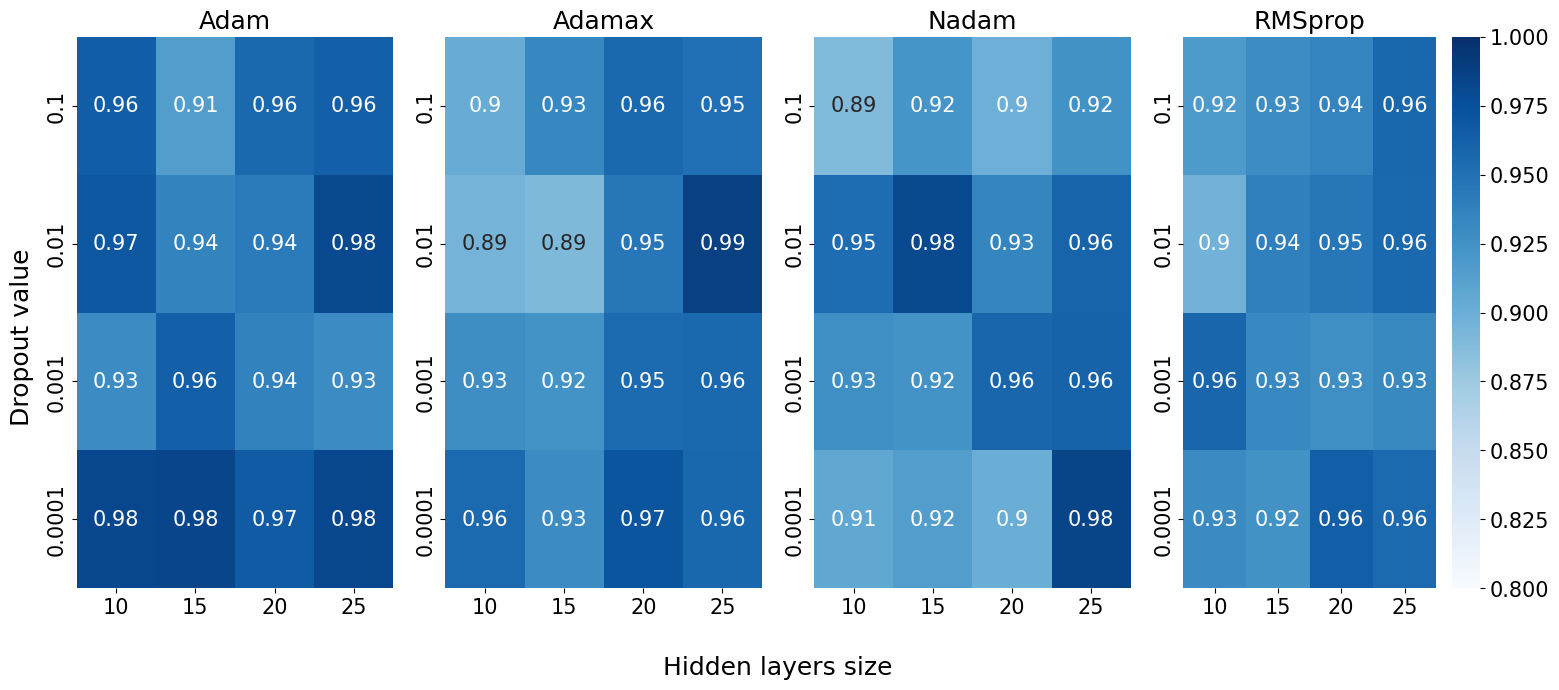

In [6]:
glob = [(m, p) for m, p in zip(means, params)]
# sort by optimizer name, alphabetically
glob = sorted(glob, key=lambda i: str(i[1]['optimizer']))

n_hsize = len(hsize_list)
n_dout = len(dout_list)
opt_chunk = n_hsize * n_dout

# human readable names for the algorithms
opt_names = ['Adam', 'Adamax', 'Nadam', 'RMSprop']

fig, ax = plt.subplots(ncols=len(optalg_list), nrows=1, figsize=(16, 7))
for i_op in range(len(optalg_list)):
    # all data from the i_op-th optimizer
    op = glob[i_op * opt_chunk:(i_op + 1) * opt_chunk]
    # dataframe with different learning rates in the columns
    # and different dropouts in the rows
    d = [[op[i + n_hsize * j][0]
          for i in range(n_hsize)]
         for j in range(n_dout)]
    df = pd.DataFrame(d, index=dout_list, columns=hsize_list)
    sns.heatmap(df, annot=True, cmap='Blues',
               # common colorbar displayed in the last plot
               ax=ax[i_op], vmin=0.8, vmax=1, cbar=i_op==3)
    # set optimizer name as title
    ax[i_op].set_title(opt_names[i_op])

# common labels
fig.supxlabel('Hidden layers size')
fig.supylabel('Dropout value')
fig.tight_layout()

## Step 5. Increasing and Reducing the Amount of Data
Here we’ll investigate what happens when we change the amount of input data: we’ll start from the previous dataset, and we’ll train our best model on different percentanges of it.

First, we’ll set the hyper-parameters to the best values that we found with the grid search.

In [7]:
best_opt = grid_result.best_params_['optimizer']
best_hsize = grid_result.best_params_['hlayer_size']
best_dout = grid_result.best_params_['dropout_rate']
print(best_opt, best_hsize, best_dout)

<class 'keras.optimizers.optimizer_v2.adamax.Adamax'> 25 0.01


We’ll fix the validation set to 20% of the total training data. Then, we’ll gradually decrease the training set size from the starting 80% and plot the results each time. We’ll display a plot for the training and validation accuracy through the epochs, a similar plot for the cross-entropy loss, and a scatter plot with the color-coded prediction of the model. 

Text(0.5, 1.0, 'Validation set (20%)')

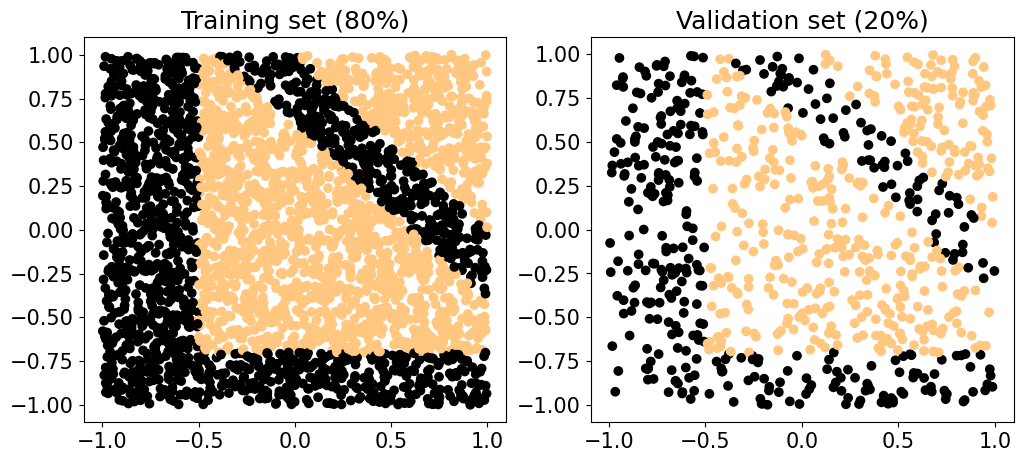

In [8]:
# first training/validation partition
(x, y) = shuffle(x, y, random_state=12345)
perc_train = 0.8
N_train = int(perc_train * N)

(x_train, y_train) = (x[0:N_train], y[0:N_train])
(x_valid, y_valid) = (x[N_train:], y[N_train:])
# data was already rescaled

# plot of the first sets
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(x_train[:, 0], x_train[:, 1], c=y_train)
ax[0].set_title('Training set (80%)')
ax[1].scatter(x_valid[:, 0], x_valid[:, 1], c=y_valid)
ax[1].set_title('Validation set (20%)')

100 % of 1st training set
25/25 [==============================] - 0s 1ms/step
95 % of 1st training set
25/25 [==============================] - 0s 2ms/step
90 % of 1st training set
25/25 [==============================] - 0s 1ms/step
85 % of 1st training set
25/25 [==============================] - 0s 1ms/step
80 % of 1st training set
25/25 [==============================] - 0s 1ms/step
75 % of 1st training set
25/25 [==============================] - 0s 671us/step
70 % of 1st training set
25/25 [==============================] - 0s 1ms/step
65 % of 1st training set
25/25 [==============================] - 0s 653us/step
60 % of 1st training set
25/25 [==============================] - 0s 649us/step
55 % of 1st training set
25/25 [==============================] - 0s 660us/step
50 % of 1st training set
25/25 [==============================] - 0s 1ms/step
45 % of 1st training set
25/25 [==============================] - 0s 593us/step
40 % of 1st training set
25/25 [=====================

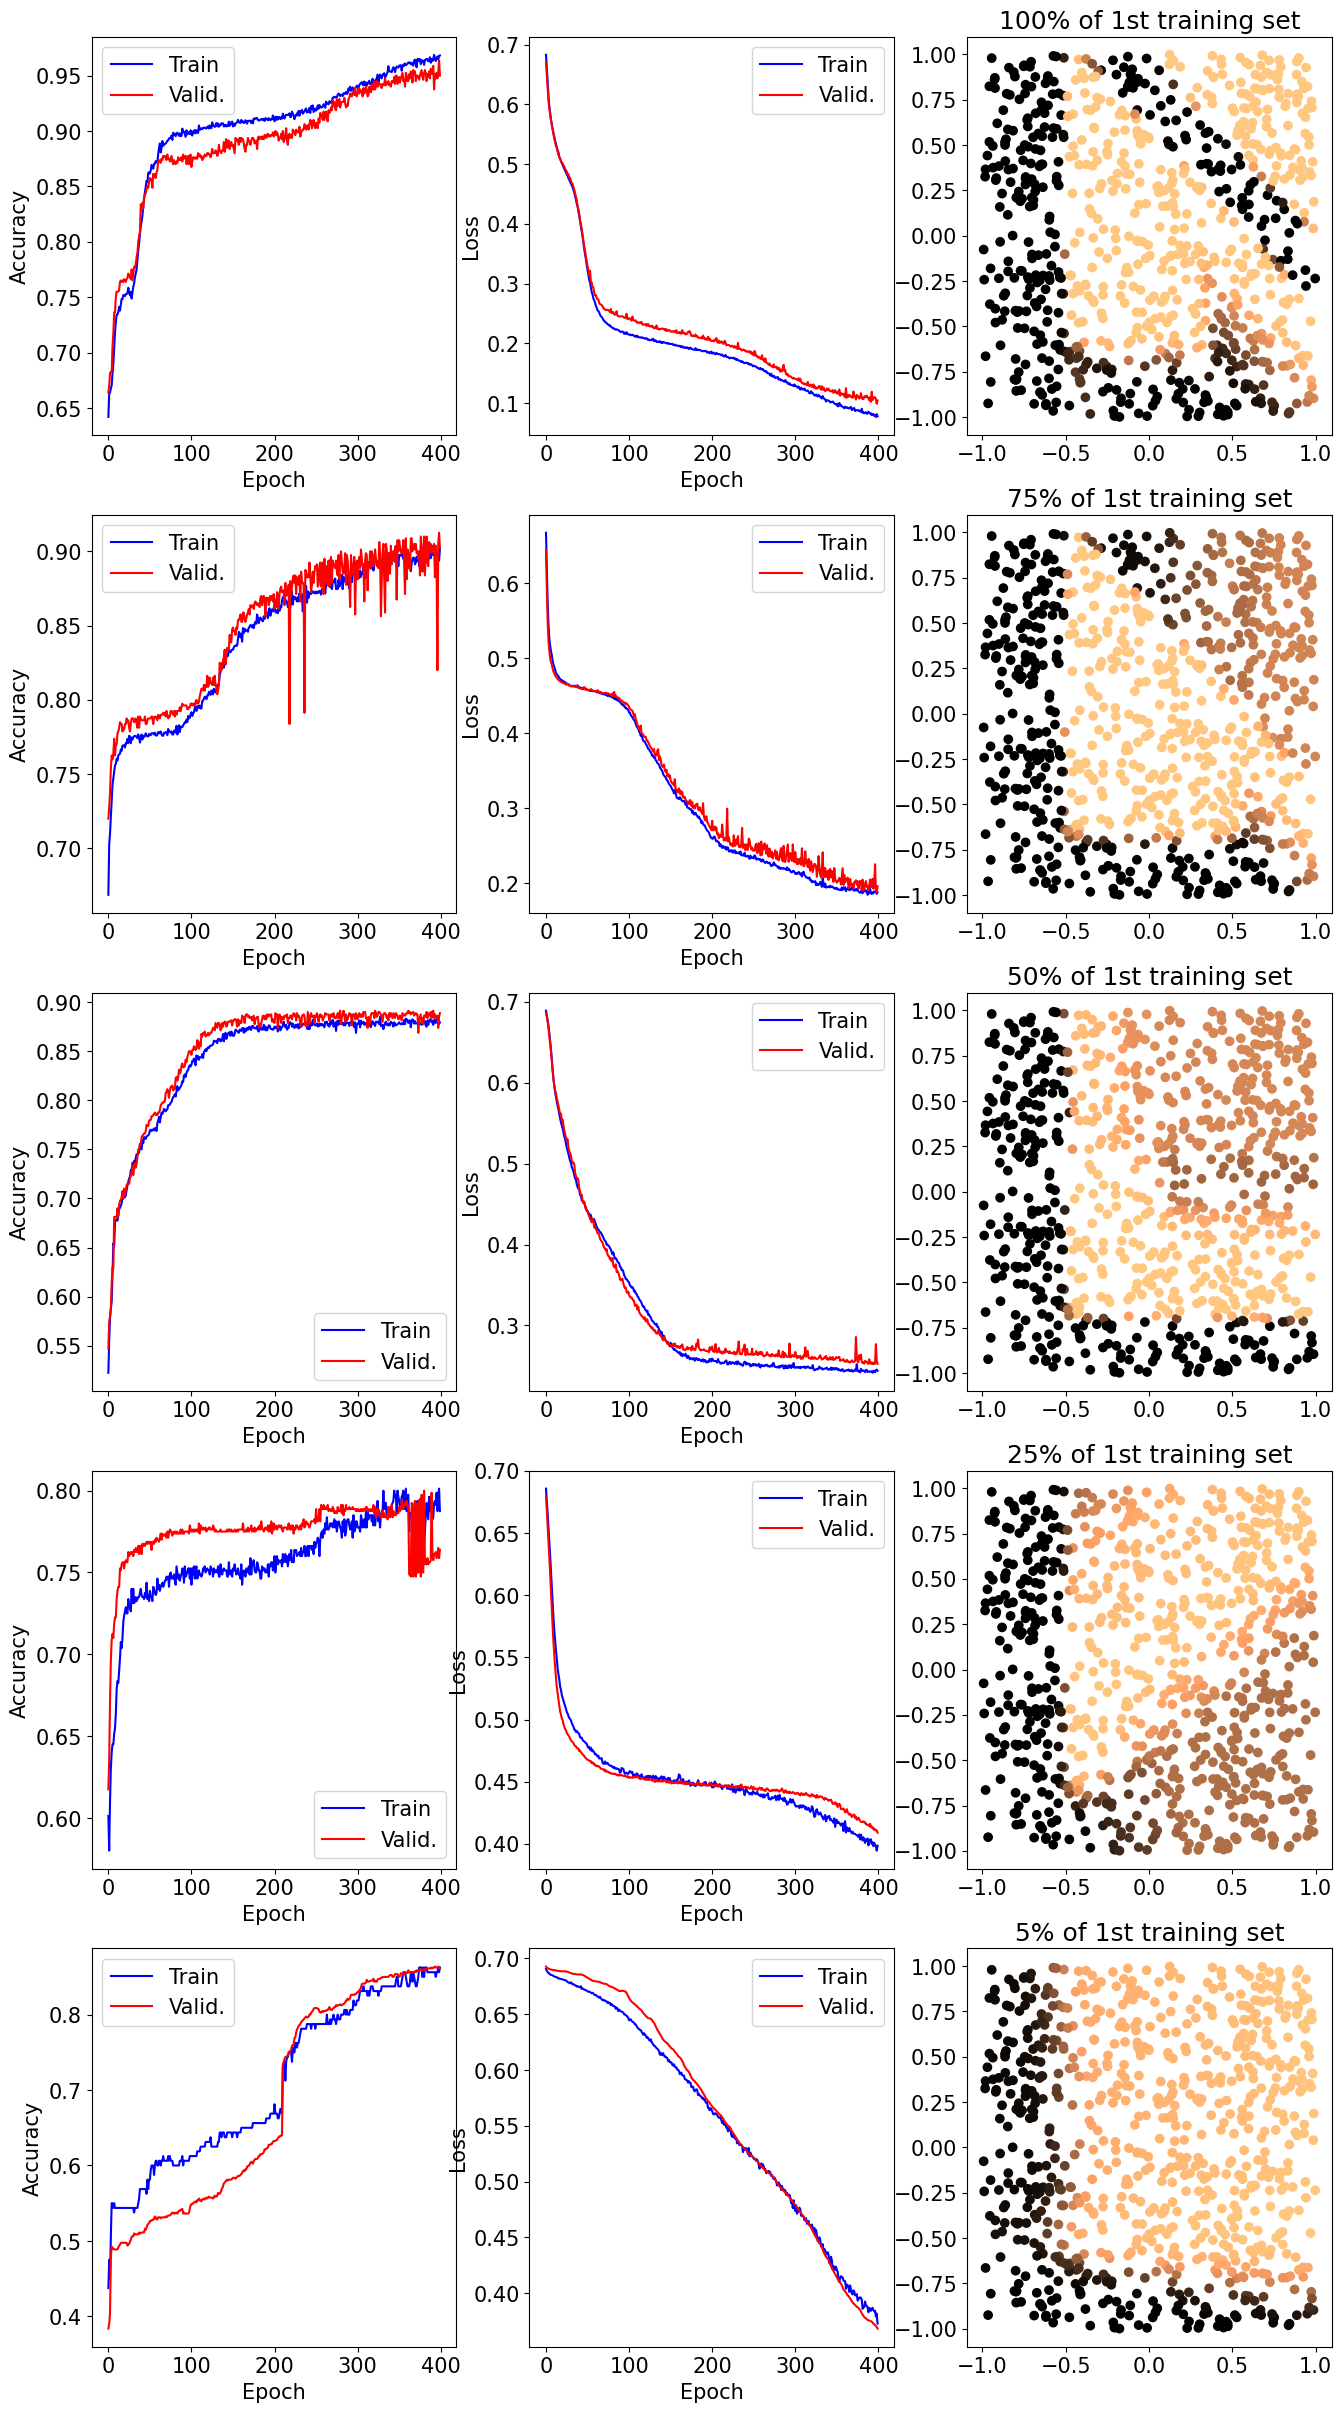

In [9]:
fig, AX = plt.subplots(5, 3, figsize=(16, 30))

# fit parameters
nepochs = 400
bsize = 50

# lists to save the losses and accuracies for later plotting
losses = []
accs = []

row = 0
percentages = range(100, 0, -5)
nrows = len(percentages)

g=0
for n in percentages:
    print(n, '% of 1st training set')
    # first shuffle
    (x_train, y_train) = shuffle(x_train, y_train, random_state=1234567)
    # then cut
    perc_train = int(N_train * n / 100)
    (x_train, y_train) = (x_train[0:perc_train], y_train[0:perc_train])

    # function to build the model defined before
    model = compile_model(best_dout, best_hsize, best_opt)

    fit = model.fit(x_train, y_train,
                    epochs=nepochs, batch_size=bsize,
                    validation_data=(x_valid, y_valid),
                    verbose=0)

    results = model.evaluate(x_valid, y_valid)
    predictions = model.predict(x_valid)

    loss, acc = results
    losses.append(loss)
    accs.append(acc)

    
    if (row % 5 == 0 or row == (nrows-1) ):
        # accuracy plot
        ax = AX[g][0]
        ax.plot(fit.history['accuracy'], label='Train', c='b')
        ax.plot(fit.history['val_accuracy'], label='Valid.', c='r')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy')
        ax.legend()

        # loss plot
        ax = AX[g][1]
        ax.plot(fit.history['loss'], label='Train', c='b')
        ax.plot(fit.history['val_loss'], label='Valid.', c='r')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()

        # prediction plot
        ax = AX[g][2]
        ax.scatter(x_valid[:, 0], x_valid[:, 1], c=predictions)
        ax.set_title(f'{n}% of 1st training set')
        g += 1
        
    row += 1

Here’s a plot of the accuracies and the losses as a function of the training set size (i.e., percentage of the first training set size).

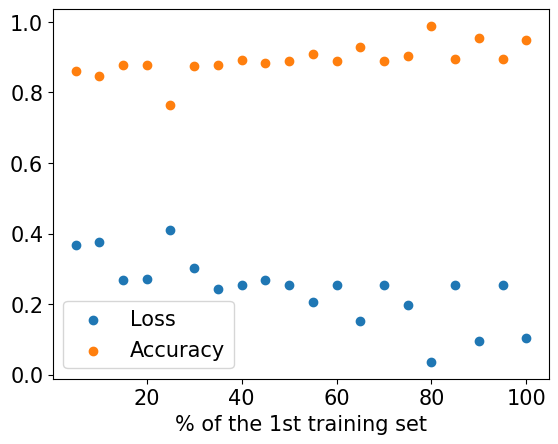

In [10]:
plt.scatter(percentages, losses, label='Loss')
plt.scatter(percentages, accs, label='Accuracy')
plt.xlabel('% of the 1st training set')
plt.legend()

## Step 6. Data Augmentation
In this section we’ll implement an *augmentation* of the training data, i.e. we’ll generate new samples by applying random transformations to the starting data. Of course, this is not at all the same as getting actual new data, so we’re investigating whether this fictitious enlargement of the training set does any good to the training.

First, we’ll report the reasoning behind our choice of the data augmentation method. To illustrate the available options and their potential issues (especially in the boundaries of the training space, which were given special attention), we’ll create a dummy dataset. Then, we’ll go over the three options we came up with.

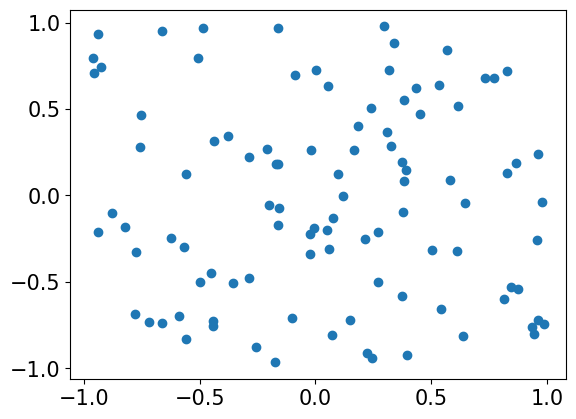

In [11]:
n = 100
data = 2 * npr.rand(2, n) - 1
plt.scatter(data[1], data[0])
plt.show()

#### First method: simply adding random noise
This is easy to implement, but the training region ends up being bigger than the validation (and original data) region.

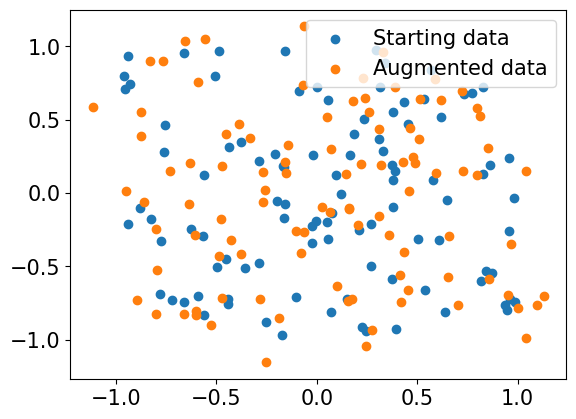

In [12]:
alpha = 0.2
data_aug = data + alpha * (2 * npr.rand(2, n) - 1)
plt.scatter(data[1], data[0], label='Starting data')
plt.scatter(data_aug[1], data_aug[0], label='Augmented data')
plt.legend()
plt.show()

#### Second method: adding random noise and truncate to the original boundaries
This is also easy to implement, it’s the same as the first with the addition of a mask. However, the augmented data density will be lower in the boundary region, due to the possible rejection of newly generated points.

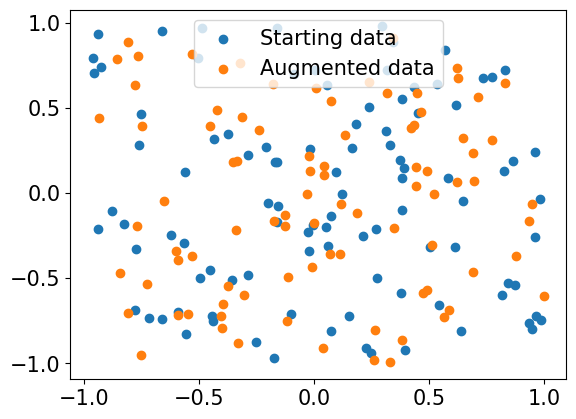

In [13]:
data_aug = data + alpha * (2 * npr.rand(2, n) - 1)

# boolean mask to remove points outside of [-1, 1] in x and y coordinates
mask = (np.abs(data_aug[0]) <= 1) & (np.abs(data_aug[1]) <= 1)
data_aug = data_aug[:, mask]

plt.scatter(data[1], data[0], label='Starting data')
plt.scatter(data_aug[1], data_aug[0], label='Augmented data')
plt.legend()
plt.show()

#### Third method: adding random noise and treat the boundaries as reflective walls
For example, if an `x` is generated as `1.03` it will be transformed to `x = 0.97`, as per a reflection. This is slightly more difficult to implement, but it should solve both of the previous issues, since samples outside the boundary are put back in the domain.

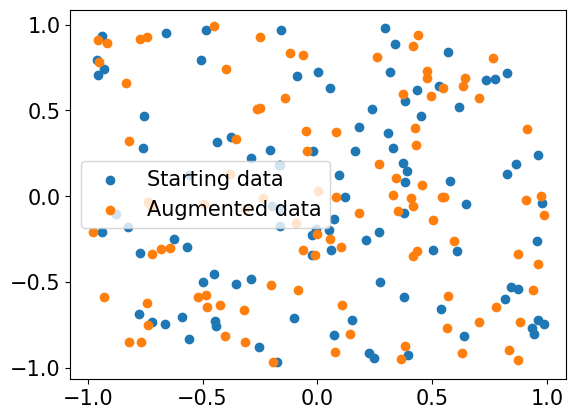

In [14]:
data_aug = data + alpha * (2 * npr.rand(2, n) - 1)

# reflect points outside of [-1, 1] in x and y coordinates
data_aug[0] = np.where(np.abs(data_aug[0]) <= 1,
                       data_aug[0],
                       np.sign(data_aug[0]) * (2 - np.abs(data_aug[0])))
data_aug[1] = np.where(np.abs(data_aug[1]) <= 1,
                       data_aug[1],
                       np.sign(data_aug[1]) * (2 - np.abs(data_aug[1])))

plt.scatter(data[1], data[0], label='Starting data')
plt.scatter(data_aug[1], data_aug[0], label='Augmented data')
plt.legend()
plt.show()


So, let’s choose the third method and proceed with the augmentation of the actual dataset.

In [15]:
perc_train = 0.8
N_train = int(perc_train * N)

(x, y) = shuffle(x, y, random_state=12345)
(x_train, y_train) = (x[0:N_train], y[0:N_train])
(x_valid, y_valid) = (x[N_train:], y[N_train:])
print(f'Number of training samples: {N_train}')
print(f'Number of validation samples: {N - N_train}')

Number of training samples: 3200
Number of validation samples: 800


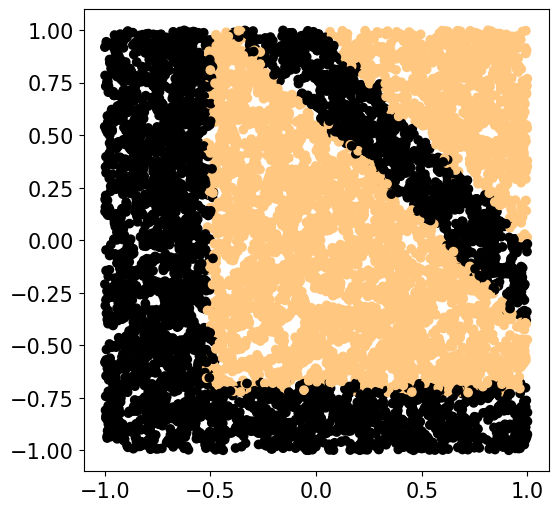

In [16]:
# number of copies of the data to augment
N_aug = 2
# a reasonable choice of the alpha parameter (after some tests)
alpha = 0.03

x_aug = x_train
y_aug = y_train
for i in range(0, N_aug):
    # generate
    data_aug_x = x_train + alpha * (2 * npr.rand(N_train, 2) - 1)
    # reflect across the boundaries
    data_aug_x[:, 0] = np.where(np.abs(data_aug_x[:, 0]) <= 1,
                                data_aug_x[:, 0],
                                np.sign(data_aug_x[:, 0])
                                        * (2 - np.abs(data_aug_x[:, 0])))
    data_aug_x[:, 1] = np.where(np.abs(data_aug_x[:, 1]) <= 1,
                                data_aug_x[:, 1],
                                np.sign(data_aug_x[:, 1])
                                        * (2 - np.abs(data_aug_x[:, 1])))
    # join to the original data
    x_aug = np.concatenate((x_aug, data_aug_x), axis=0)
    y_aug = np.concatenate((y_aug, y_train))

plt.figure(figsize=(6, 6))
plt.scatter(x_aug[:, 0], x_aug[:, 1], c=y_aug)
plt.show()

Then, we train the model with the best architecture…

In [17]:
model = compile_model(dropout_rate=best_dout,
                      hlayer_size=best_hsize,
                      optimizer=best_opt)

fit = model.fit(x_aug, y_aug,
                epochs=1000, batch_size=bsize,
                validation_data=(x_valid, y_valid),
                verbose=0)

… and visualize the results.

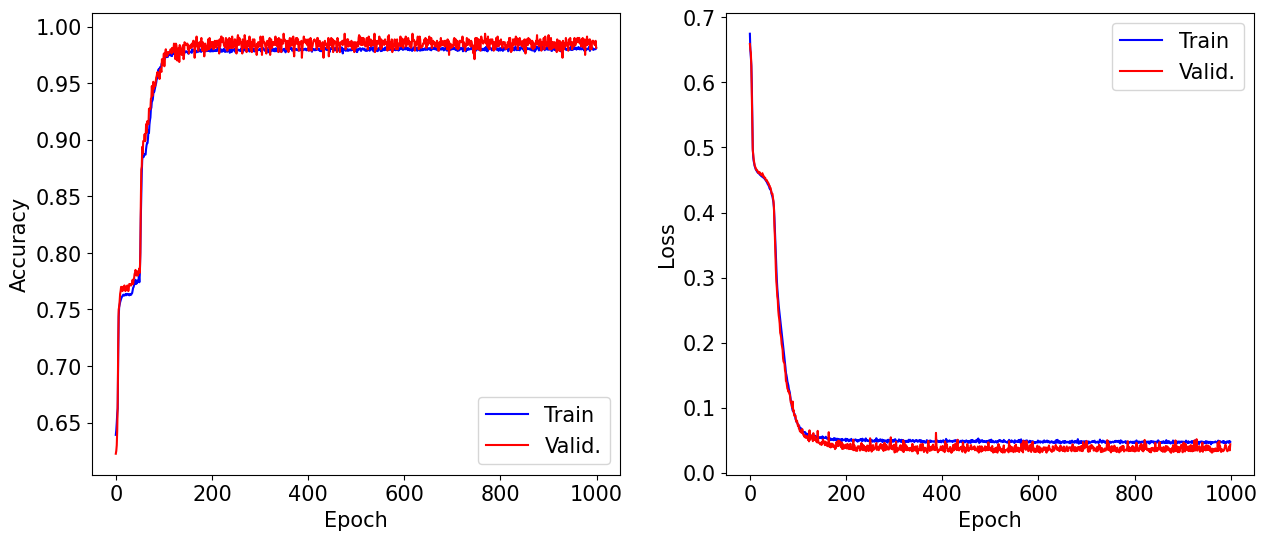

In [18]:
fig, AX = plt.subplots(1, 2, figsize=(15, 6))

ax = AX[0]
ax.plot(fit.history['accuracy'], label='Train', c='b')
ax.plot(fit.history['val_accuracy'], label='Valid.', c='r')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

ax = AX[1]
ax.plot(fit.history['loss'], label='Train', c='b')
ax.plot(fit.history['val_loss'], label='Valid.', c='r')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

plt.show()

Now, we’ll plot the data with the prediction, highlighting the region where the predicted label is bigger than $1/2$.

82/82 [==============================] - 0s 1ms/step


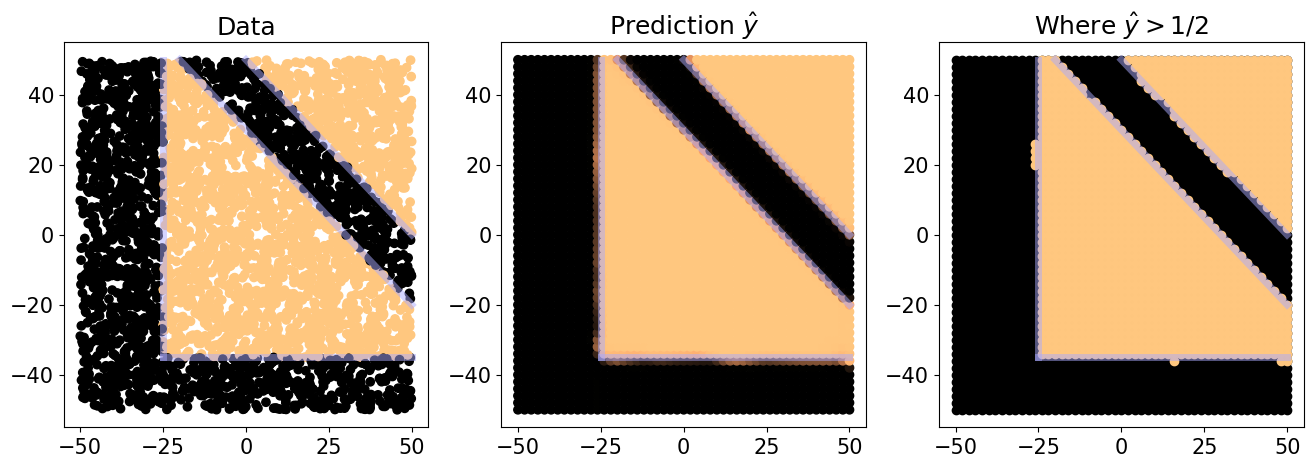

In [19]:
dX = 2
X1 = np.arange(-50, 50 + dX, dX)
LG = len(X1)

grid = np.zeros((LG * LG, 2))
k = 0

for i in range(LG):
    for j in range(LG):
        grid[k, :] = (X1[j], X1[i])
        k += 1
grid_r = grid / 50

pred = model.predict(grid_r)

def boundaries():  
    x1 = -25
    y1 = -35
    c = '#AAAAFF'
    a = 0.5
    lw = 5
    ax.plot((50, -20), (-20, 50), c=c, alpha=a, lw=lw)
    ax.plot((50, 0), (0, 50), c=c, alpha=a, lw=lw)
    ax.plot((x1, 50), (y1, y1), c=c, alpha=a, lw=lw)
    ax.plot((x1, x1), (y1, 50),c=c, alpha=a, lw=lw)

fig, AX = plt.subplots(1, 3, figsize =(16, 5))

ax = AX[0]
ax.scatter(x[:, 0] * 50, x[:, 1] * 50, c=y)
boundaries()
ax.set_title('Data')

ax = AX[1]
ax.scatter(grid[:, 0], grid[:, 1], c=pred)
boundaries()
ax.set_title('Prediction $\\hat y$')

ax = AX[2]
W1 = np.where(pred > 0.5)[0] 
ax.scatter(grid[:, 0], grid[:, 1], c='#000000')
ax.scatter(grid[W1, 0], grid[W1, 1], c='#ffc77f')
boundaries()
ax.set_title('Where $\\hat y > 1/2$')
plt.show()

Testing with various amounts of noise ($0.01 < \alpha < 0.05$) shows that, despite satisfying performances on the validation set, the training on augmented data can never be as stable, reliable and efficient as the training on just real data. This is reasonable, since random noise is, by definition, not learnable; so, at best we can achieve the same result as before.